In [1]:
from collections import Counter
import random
import gc
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from easydict import EasyDict as edict
from imutils.paths import list_images
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.metrics import *
import torch.optim as optim
import albumentations as A
from tqdm import tqdm
from PIL import Image
import torch.nn as nn
import hiplot as hip
import pandas as pd
import numpy as np
import torch
import timm
import cv2

2023-04-14 05:25:06.514479: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
ROOT_PATH  = '/'.join(os.getcwd().split('/')[:-1])
DATA_PATH  = f'{ROOT_PATH}/TIL/dataset/Dacon'

args       = {}
args['LR']             = 1e-3
args['Decay']          = 1e-5
args['EPOCHS']         = 10
args['device']         = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
args['BATCH_SIZE']     = 64
args['early_stopping'] = args['EPOCHS'] // 2 

args['horizontal_flip'] = False
args['vertical_flip']   = False
args['height_shift']    = 0.1
args['width_shift']     = 0.1
args['number']          = 400
args['angle']           = 15

args = edict(args)
args.device

device(type='cuda')

In [3]:
lb2idx = {lb  : idx for idx, lb in enumerate(os.listdir(f'{DATA_PATH}/train'))}
idx2lb = {idx : lb for lb, idx in lb2idx.items()} 
idx2lb

{0: '울음',
 1: '꼬임',
 2: '가구수정',
 3: '오타공',
 4: '걸레받이수정',
 5: '틈새과다',
 6: '들뜸',
 7: '오염',
 8: '몰딩수정',
 9: '면불량',
 10: '녹오염',
 11: '터짐',
 12: '피스',
 13: '훼손',
 14: '석고수정',
 15: '이음부불량',
 16: '곰팡이',
 17: '창틀,문틀수정',
 18: '반점'}

In [4]:
def data_split4eachlb(image_paths):
    
    splited_dataset = {lb : [] for lb in lb2idx.keys()}
    for image_path in image_paths:
        
        lb = image_path.split(os.path.sep)[-2]
        splited_dataset[lb].append(image_path)
        
    return splited_dataset
        

def data_undersampling(image_paths, n_datas = 400):
    
    splited_dataset = data_split4eachlb(image_paths)
    rest_dataset    = []
    under_dataset   = []
    
    for lb in lb2idx.keys():
        
        data = splited_dataset[lb]
        if len(data) > n_datas:
            random.shuffle(data)
            rest_dataset.extend(data[n_datas:])
            under_dataset.extend(data[:n_datas])
            
        else: under_dataset.extend(data)
    
    return under_dataset, rest_dataset


def augmentation(image_path, aug_option):

    image          = img_to_array(cv2.imread(image_path))
    image          = np.expand_dims(image, axis = 0)

    augmented      = aug_option.flow(image, batch_size = 1)
    augmented      = augmented.next()
    augmented      = augmented[0].astype('uint8')

    return augmented


def data_oversampling(image_paths, n_datas = 400):
    
    aug_option = ImageDataGenerator(
                                        height_shift_range = args.height_shift,
                                        width_shift_range  = args.width_shift,
                                        horizontal_flip    = args.horizontal_flip,
                                        rotation_range     = args.angle,
                                        vertical_flip      = args.vertical_flip,
                                    )
    labels       = lb_extractor(image_paths)
    lb_counts    = Counter(labels)
    splited_data = data_split4eachlb(image_paths)
    
    for lb, value in lb_counts.items():
        
        lb = idx2lb[lb]
        if value >= n_datas: 
            
            print(f'늘려야 할 데이터 수 보다 많으므로 증강시키지 않습니다. {value}\n')
    
        else:
            
            iter_for_each = (n_datas - value) / value
            condition     = [iter_for_each < 0, iter_for_each > 1]
            
            print(f'현재 데이터 수는 {value}이고, 늘려야 하는 데이터 셋 수는 {n_datas - value}입니다.')
            
            if all(condition):
                print(f'{lb} : 한 장당 늘려야 하는 이미지가 1개 미만이므로, 랜덤으로 선택해 늘립니다.')
                sample_datas = random.sample(splited_data[lb], n_datas - value)
                print(f'샘플 데이터의 개수 입니다. {len(sample_datas)}')
                
                for image_path in sample_datas: 
                    
                    augmented      = augmentation(image_path, aug_option)
                    file_name      = image_path.split(os.path.sep)[-1]
                    file_name, ext = os.path.splitext(file_name)
                    
                    cv2.imwrite(f'{DATA_PATH}/train/{lb}/{file_name}_aug.{ext}', augmented)
                    
            else:

                residue    = (n_datas - value) % value
                random_idx = random.choice(range(len(splited_data[lb])))
                
                print(f'{lb} : 한 장 당 늘려야 하는 이미지의 갯수가 1개 이상 이므로, 전체 데이터 셋을 늘립니다.')
                print(f'{random_idx} 번째 이미지는 다른 이미지보다 {residue}장 더 늘립니다. \n')
                
                for odx, image_path in enumerate(splited_data[lb], 1):
                    
                    fixed_iter_for_each = iter_for_each if odx != random_idx else (iter_for_each + residue)
                    
                    for idx in range(int(fixed_iter_for_each)):
                        
                        augmented      = augmentation(image_path, aug_option)
                        file_name      = image_path.split(os.path.sep)[-1]
                        file_name, ext = os.path.splitext(file_name)
                        cv2.imwrite(f'{DATA_PATH}/train/{lb}/{file_name}_aug_{idx}.{ext}', augmented)
            
            after = sorted(list_images(f"{DATA_PATH}/train/{lb}"))
            print(f'데이터 증강 완료한 데이터 수는 {len(after)} 입니다.\n')
                        
    return sorted(list_images(f'{DATA_PATH}/train')) 
                        

def show_distribution(labels):
    
    lb_count = Counter(labels)
    plt.bar(lb_count.keys(), lb_count.values())
    
    for k, v in lb_count.items():
        
        plt.text(
                    k, v, v,
                    verticalalignment   = 'bottom',
                    horizontalalignment = 'center'
            )

        
lb_extractor = lambda image_paths: [lb2idx[image_path.split(os.path.sep)[-2]] for image_path in image_paths]

{'울음': 0,
 '꼬임': 1,
 '가구수정': 2,
 '오타공': 3,
 '걸레받이수정': 4,
 '틈새과다': 5,
 '들뜸': 6,
 '오염': 7,
 '몰딩수정': 8,
 '면불량': 9,
 '녹오염': 10,
 '터짐': 11,
 '피스': 12,
 '훼손': 13,
 '석고수정': 14,
 '이음부불량': 15,
 '곰팡이': 16,
 '창틀,문틀수정': 17,
 '반점': 18}

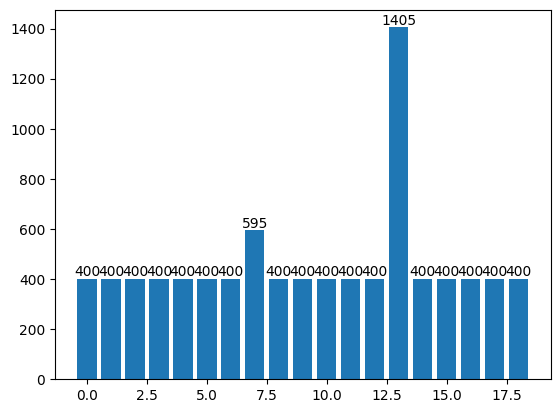

In [5]:
image_paths = sorted(list_images(f'{DATA_PATH}/train'))

show_distribution(lb_extractor(image_paths))
lb2idx

늘려야 할 데이터 수 보다 많으므로 증강시키지 않습니다. 400

늘려야 할 데이터 수 보다 많으므로 증강시키지 않습니다. 400

늘려야 할 데이터 수 보다 많으므로 증강시키지 않습니다. 400

늘려야 할 데이터 수 보다 많으므로 증강시키지 않습니다. 400

늘려야 할 데이터 수 보다 많으므로 증강시키지 않습니다. 400

늘려야 할 데이터 수 보다 많으므로 증강시키지 않습니다. 400

늘려야 할 데이터 수 보다 많으므로 증강시키지 않습니다. 400

늘려야 할 데이터 수 보다 많으므로 증강시키지 않습니다. 400

늘려야 할 데이터 수 보다 많으므로 증강시키지 않습니다. 400

늘려야 할 데이터 수 보다 많으므로 증강시키지 않습니다. 400

늘려야 할 데이터 수 보다 많으므로 증강시키지 않습니다. 400

늘려야 할 데이터 수 보다 많으므로 증강시키지 않습니다. 400

늘려야 할 데이터 수 보다 많으므로 증강시키지 않습니다. 400

늘려야 할 데이터 수 보다 많으므로 증강시키지 않습니다. 400

늘려야 할 데이터 수 보다 많으므로 증강시키지 않습니다. 400

늘려야 할 데이터 수 보다 많으므로 증강시키지 않습니다. 400

늘려야 할 데이터 수 보다 많으므로 증강시키지 않습니다. 400

늘려야 할 데이터 수 보다 많으므로 증강시키지 않습니다. 400

늘려야 할 데이터 수 보다 많으므로 증강시키지 않습니다. 400



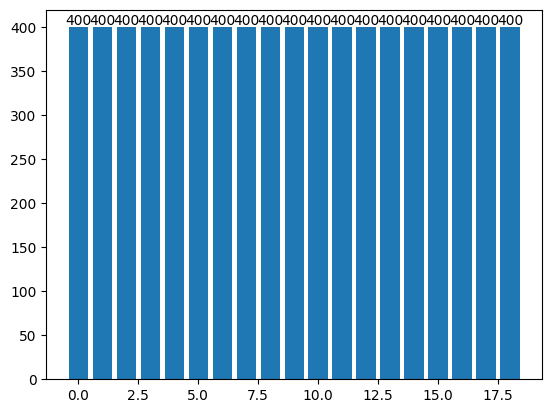

In [31]:
image_paths               = data_oversampling(image_paths)
image_paths, rest_dataset = data_undersampling(image_paths)

labels = lb_extractor(image_paths)
show_distribution(labels)

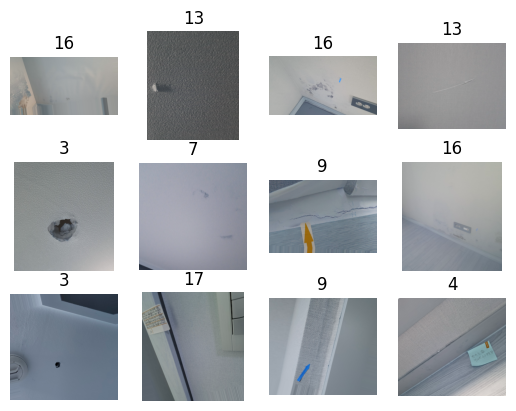

In [7]:
_, plots = plt.subplots(3, 4)

for odx in range(4):
    for idx in range(3):
        
        image_path = random.choice(image_paths)
        label      = image_path.split(os.path.sep)[-2]
        image      = cv2.imread(image_path)
        
        plots[idx][odx].imshow(image)
        plots[idx][odx].set_title(lb2idx[label])
        plots[idx][odx].axis(False)

In [8]:
train_x, test_x, train_y, test_y  = train_test_split(image_paths, labels, test_size = 0.2, 
                                                     stratify = labels, random_state = 99, shuffle = True)

train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size = 0.2, 
                                                      stratify = train_y, random_state = 99, shuffle = True)

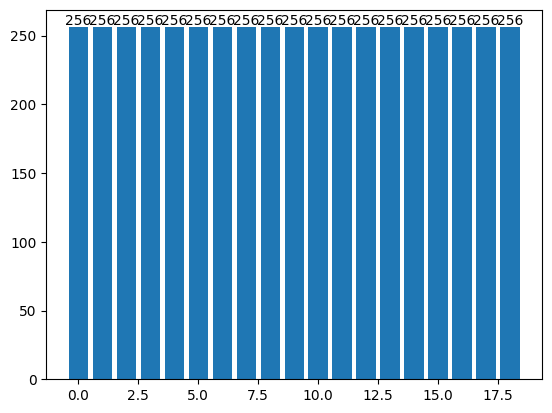

In [9]:
show_distribution(train_y)

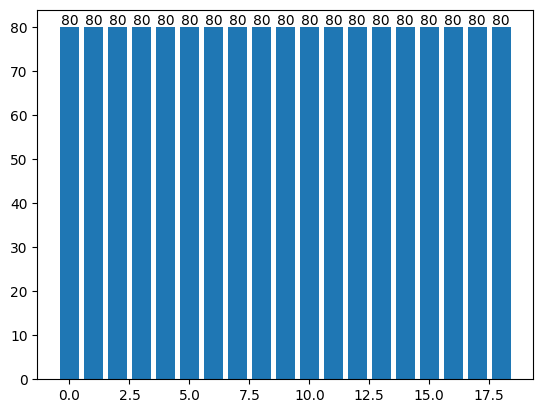

In [10]:
show_distribution(test_y)

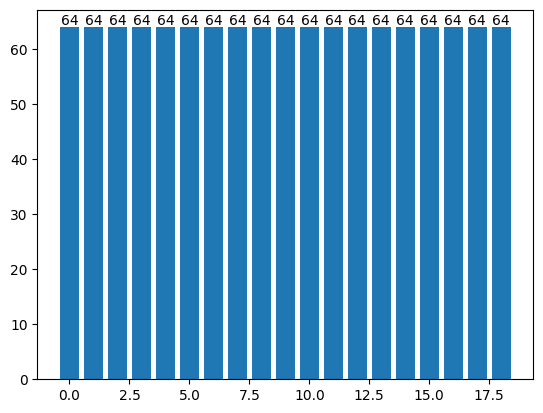

In [11]:
show_distribution(valid_y)

In [12]:
class PaperingDataset(Dataset):
    
    def __init__(self, image_paths, labels, dtype = 'train'):
        
        self.image_paths = image_paths
        self.labels      = np.array(labels)
        self.dtype       = dtype
        
        self.transform   = {
                                'train' : transforms.Compose([
                                                transforms.ToPILImage(),
                                                transforms.Resize((299, 299)),
                                                transforms.RandomHorizontalFlip(),
                                                transforms.RandomVerticalFlip(),
                                                transforms.ToTensor(),
                                            ]),
            
                                'valid' : transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((299, 299)),
                                        transforms.ToTensor()
                                ])
                            }
        
    
    def __len__(self):
        
        return self.labels.shape[0]
    
    
    def __getitem__(self, idx):
        
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transform[self.dtype](image)
        
        return image, self.labels[idx]

(-0.5, 298.5, 298.5, -0.5)

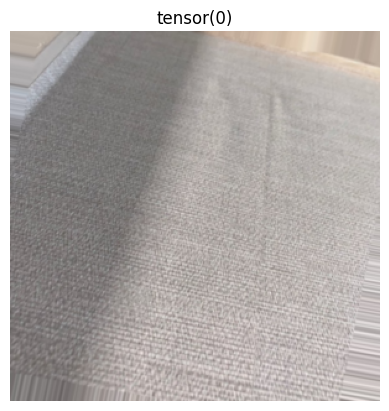

In [13]:
train_dataset         = PaperingDataset(train_x, train_y)
train_loader          = DataLoader(train_dataset, shuffle = True, batch_size = args.BATCH_SIZE)
sample_img, sample_lb = next(iter(train_loader))

plt.imshow(np.transpose(sample_img[0], (1, 2, 0)))
plt.title(sample_lb[0])
plt.axis(False)

(-0.5, 298.5, 298.5, -0.5)

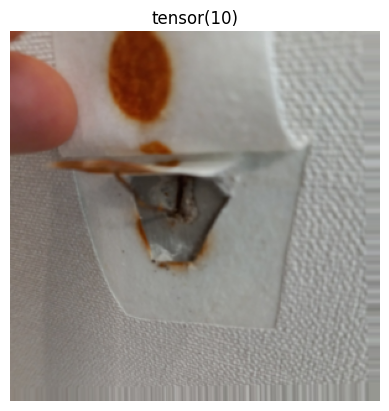

In [14]:
valid_dataset         = PaperingDataset(valid_x, valid_y, dtype = 'valid')
valid_loader          = DataLoader(valid_dataset, shuffle = False, batch_size = args.BATCH_SIZE)
sample_img, sample_lb = next(iter(valid_loader))

plt.imshow(np.transpose(sample_img[0], (1, 2, 0)))
plt.title(sample_lb[0])
plt.axis(False)

(-0.5, 298.5, 298.5, -0.5)

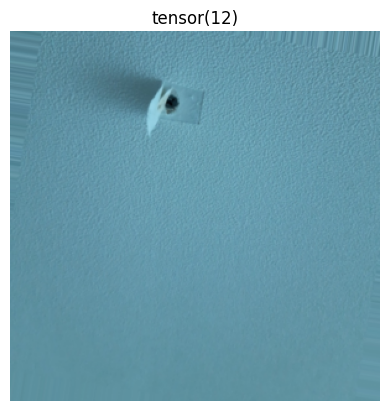

In [15]:
test_dataset          = PaperingDataset(test_x, test_y, dtype = 'valid')
test_loader           = DataLoader(test_dataset, shuffle = False, batch_size = 1)
sample_img, sample_lb = next(iter(test_loader))

plt.imshow(np.transpose(sample_img[0], (1, 2, 0)))
plt.title(sample_lb[0])
plt.axis(False)

In [16]:
class PaperingModel(nn.Module):
    
    def __init__(self, num_classes = set(labels)):
        
        super(PaperingModel, self).__init__()
        
        self.base_model = timm.create_model('inception_v4',
                                            pretrained = True, num_classes = num_classes)
        
    
    def forward(self, x):
        
        output = self.base_model(x)
        return output

In [17]:
criterion = nn.CrossEntropyLoss()
history = {
           'train' : {'accuracy' : [], 'loss' : [], 'f1' : []},
           'valid' : {'accuracy' : [], 'loss' : [], 'f1' : []}
          }

def get_optimizer(model):
    
    optimizer = optim.Adam(model.parameters(), lr = args.LR, weight_decay = args.Decay)
    optimizer.zero_grad()
    
    return optimizer


def train(model, train_loader, optimizer):
    
    model.train()
    total_loss, correct = 0, 0
    gt, predicted       = [], []
    
    for (images, labels) in tqdm(train_loader):
        images, labels = images.float().to(args.device), labels.to(args.device)
        
        outputs        = model(images)
        loss           = criterion(outputs, labels.data)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        _, preds    = torch.max(outputs, 1)
        
        predicted  += preds.detach().cpu().numpy().tolist()
        gt         += labels.detach().cpu().numpy().tolist()
        
        correct    += torch.sum(preds == labels)
        total_loss += loss
    
    avg_loss    = total_loss / len(train_loader)
    accuracy    = correct / (len(train_loader) * args.BATCH_SIZE)
    weighted_f1 = f1_score(gt, predicted, average = 'weighted')
    
    history['train']['loss'].append(avg_loss)
    history['train']['accuracy'].append(accuracy)
    history['train']['f1'].append(weighted_f1)
    
    print(f'[TRAIN] accuracy : {accuracy:.2f} | loss : {avg_loss:.2f} | weight f1 : {weighted_f1:.2f}')
    return accuracy


def validation(model, valid_loader):
    model.eval()
    total_loss, correct = 0, 0
    gt, predicted       = [], []
    
    with torch.no_grad():
        for (images, labels) in tqdm(valid_loader):
            images, labels = images.float().to(args.device), labels.to(args.device)

            outputs = model(images)
            loss    = criterion(outputs, labels)

            _, preds    = torch.max(outputs, 1)
            correct    += torch.sum(preds == labels.data)
            total_loss += loss.item()

            predicted  += preds.detach().cpu().numpy().tolist()
            gt         += labels.detach().cpu().numpy().tolist()

    avg_loss    = total_loss / len(valid_loader)
    accuracy    = correct / (len(valid_loader)*args.BATCH_SIZE)
    weighted_f1 = f1_score(gt, predicted, average = 'weighted')
    
    history['valid']['loss'].append(avg_loss)
    history['valid']['accuracy'].append(accuracy)
    history['valid']['f1'].append(weighted_f1)
    
    print(f'[VALID] accuracy : {accuracy:.2f} | loss : {avg_loss:.2f} | weight f1 : {weighted_f1:.2f}')
    return accuracy, outputs    

In [18]:
def run(model, train_loader, valid_loader):
  optimizer     = get_optimizer(model)

  early_stopping_counter = 0
  best_acc               = -1

  for epoch in range(args.EPOCHS):
    print(f'[{epoch + 1} / {args.EPOCHS}]')

    train_acc          = train(model, train_loader, optimizer)
    valid_acc, outputs = validation(model, valid_loader)

    if valid_acc > best_acc:
        os.makedirs('models/', exist_ok = True)
        
        best_acc               = valid_acc
        early_stopping_counter = 0
        
        torch.save(model, 'models/best_model.pt')
        print(f'save model with accuracy : {best_acc}')

    else:
        early_stopping_counter += 1
        if early_stopping_counter >= args.early_stopping:
            print(f'Training Stopped by Early stopping counter : {early_stopping_counter}')
            break


In [19]:
torch.cuda.empty_cache()
gc.collect()

model = PaperingModel(num_classes = len(labels))
model.to(args.device)

run(model, train_loader, valid_loader)

[1 / 10]


100%|██████████| 76/76 [01:43<00:00,  1.36s/it]


[TRAIN] accuracy : 0.65 | loss : 1.50 | weight f1 : 0.65


100%|██████████| 19/19 [00:20<00:00,  1.10s/it]


[VALID] accuracy : 0.72 | loss : 0.89 | weight f1 : 0.71
save model with accuracy : 0.7220394611358643
[2 / 10]


100%|██████████| 76/76 [01:39<00:00,  1.31s/it]


[TRAIN] accuracy : 0.80 | loss : 0.67 | weight f1 : 0.80


100%|██████████| 19/19 [00:21<00:00,  1.12s/it]


[VALID] accuracy : 0.76 | loss : 0.71 | weight f1 : 0.75
save model with accuracy : 0.7639802694320679
[3 / 10]


100%|██████████| 76/76 [01:42<00:00,  1.35s/it]


[TRAIN] accuracy : 0.84 | loss : 0.51 | weight f1 : 0.84


100%|██████████| 19/19 [00:20<00:00,  1.08s/it]


[VALID] accuracy : 0.79 | loss : 0.71 | weight f1 : 0.79
save model with accuracy : 0.7935855388641357
[4 / 10]


100%|██████████| 76/76 [01:42<00:00,  1.34s/it]


[TRAIN] accuracy : 0.85 | loss : 0.47 | weight f1 : 0.85


100%|██████████| 19/19 [00:22<00:00,  1.16s/it]


[VALID] accuracy : 0.85 | loss : 0.59 | weight f1 : 0.84
save model with accuracy : 0.8453947305679321
[5 / 10]


100%|██████████| 76/76 [01:41<00:00,  1.34s/it]


[TRAIN] accuracy : 0.89 | loss : 0.36 | weight f1 : 0.89


100%|██████████| 19/19 [00:21<00:00,  1.15s/it]


[VALID] accuracy : 0.86 | loss : 0.45 | weight f1 : 0.86
save model with accuracy : 0.8610197305679321
[6 / 10]


100%|██████████| 76/76 [01:44<00:00,  1.38s/it]


[TRAIN] accuracy : 0.91 | loss : 0.28 | weight f1 : 0.91


100%|██████████| 19/19 [00:22<00:00,  1.20s/it]


[VALID] accuracy : 0.84 | loss : 0.59 | weight f1 : 0.84
[7 / 10]


100%|██████████| 76/76 [01:46<00:00,  1.40s/it]


[TRAIN] accuracy : 0.91 | loss : 0.29 | weight f1 : 0.91


100%|██████████| 19/19 [00:20<00:00,  1.09s/it]


[VALID] accuracy : 0.84 | loss : 0.51 | weight f1 : 0.85
[8 / 10]


100%|██████████| 76/76 [01:43<00:00,  1.36s/it]


[TRAIN] accuracy : 0.93 | loss : 0.24 | weight f1 : 0.93


100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


[VALID] accuracy : 0.89 | loss : 0.36 | weight f1 : 0.88
save model with accuracy : 0.8856908082962036
[9 / 10]


100%|██████████| 76/76 [01:49<00:00,  1.44s/it]


[TRAIN] accuracy : 0.94 | loss : 0.18 | weight f1 : 0.94


100%|██████████| 19/19 [00:23<00:00,  1.26s/it]


[VALID] accuracy : 0.89 | loss : 0.37 | weight f1 : 0.89
save model with accuracy : 0.8947368264198303
[10 / 10]


100%|██████████| 76/76 [01:57<00:00,  1.54s/it]


[TRAIN] accuracy : 0.94 | loss : 0.19 | weight f1 : 0.94


100%|██████████| 19/19 [00:25<00:00,  1.36s/it]

[VALID] accuracy : 0.87 | loss : 0.48 | weight f1 : 0.87


In [24]:
def evaluation(model, test_loader):
    
    model.eval()
    
    total_loss, correct = 0, 0
    gt, predicted       = [], []
    
    with torch.no_grad():
        for (images, labels) in tqdm(test_loader):
            images, labels = images.float().to(args.device), labels.to(args.device)

            outputs = model(images)
            loss    = criterion(outputs, labels)

            _, preds    = torch.max(outputs, 1)
            correct    += torch.sum(preds == labels.data)
            total_loss += loss.item()

            predicted  += preds.detach().cpu().numpy().tolist()
            gt         += labels.detach().cpu().numpy().tolist()

    avg_loss    = total_loss / len(test_loader)
    accuracy    = correct / (len(test_loader))
    weighted_f1 = f1_score(gt, predicted, average = 'weighted')

    print(f'[test] accuracy : {accuracy:.2f} | loss : {avg_loss:.2f} | weight f1 : {weighted_f1:.2f}')
    return classification_report(gt, predicted, target_names = lb2idx.keys())

In [25]:
report = evaluation(model, test_loader)
print(report)

100%|██████████| 1520/1520 [01:00<00:00, 25.30it/s]

[test] accuracy : 0.88 | loss : 0.45 | weight f1 : 0.88
              precision    recall  f1-score   support

          울음       0.94      0.99      0.96        80
          꼬임       0.91      0.96      0.93        80
        가구수정       0.96      1.00      0.98        80
         오타공       0.84      0.57      0.68        80
      걸레받이수정       0.94      0.74      0.83        80
        틈새과다       0.96      1.00      0.98        80
          들뜸       0.96      0.97      0.97        80
          오염       0.77      0.66      0.71        80
        몰딩수정       0.97      0.75      0.85        80
         면불량       0.79      0.76      0.78        80
         녹오염       0.98      0.99      0.98        80
          터짐       0.82      0.90      0.86        80
          피스       0.96      0.93      0.94        80
          훼손       0.56      0.72      0.63        80
        석고수정       0.72      0.88      0.79        80
       이음부불량       0.99      1.00      0.99        80
         곰팡이       0.77  

In [32]:
rest_labels  = lb_extractor(rest_dataset)
predicted    = []

for rest_path, rest_lb in tqdm(zip(rest_dataset, rest_labels)):
    
    transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((299, 299)),
                transforms.ToTensor()
            ])

    image = cv2.imread(rest_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = transform(image).float().to(args.device)
    image = image.unsqueeze(0)

    outputs   = model(image)
    _, preds  = torch.max(outputs, 1)
    
    idx = preds.detach().cpu().numpy().tolist()[0]
    predicted.append(idx)
    
print(classification_report(rest_labels, predicted))

1200it [00:53, 22.41it/s]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.62      0.75      0.68       195
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.97      0.74      0.84      1005
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         0
          17       0.00    


/opt/conda/envs/tensor/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/tensor/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/tensor/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
submit_df  = pd.read_csv(f'{DATA_PATH}/test.csv')
test_paths = sorted([f'{DATA_PATH}/test/{image.split("_")[1]}.png' for image in submit_df['id']])
submit     = []

for test_path in tqdm(test_paths):
    
    transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((299, 299)),
                transforms.ToTensor()
            ])

    image = cv2.imread(test_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = transform(image).float().to(args.device)
    image = image.unsqueeze(0)

    outputs   = model(image)
    _, preds  = torch.max(outputs, 1)
    
    idx = preds.detach().cpu().numpy().tolist()[0]
    submit.append(idx2lb[idx])
    
submits          = pd.read_csv(f'{DATA_PATH}/sample_submission.csv')
submits['label'] = submit
submits.to_csv('submit.csv', index = False)

100%|██████████| 792/792 [00:35<00:00, 22.54it/s]
